# Tutorial

In [260]:
# enable auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

## 1. Load Preprocessed Data

In [262]:
RAW_PATH = './data'            # path to raw data
NP_PATH = './preprocessed'     # path to preprocessed data
FRAME_LEN = 1024               # length of one data frame
FRAME_INTV = 512               # interval between data frames

In [263]:
if not os.path.exists(NP_PATH):
    os.mkdir(NP_PATH)

In [264]:
from src.utils.data_utils import get_preprocessed_data
#for more information, please look up <get_preprocessed_data> in './src/utils/data_utils.py'

DATA, train_idx, test_idx, trainY, testY, train_diameter, test_diameter, train_rpm, test_rpm = get_preprocessed_data(RAW_PATH, NP_PATH, FRAME_LEN, FRAME_INTV)

### Data Description
- **DATA** :  full sequence of bearing data *(total_length, 1)*
    
- **train_idx / test_idx** : initial point of each frames in train/test set *(dataset_size,)*

- **trainY / testY** : true labels of train/test set *(dataset_size,)*
    
- **train_diameter / test_diameter** : fault diameters of train/test set *(dataset_size,)*


![title](resources/1.png)


## 2. Quick Understanding for Data

***You can also test yourself in <DataAnalysis.ipynb>***

*Let's plot the entire dataset!*

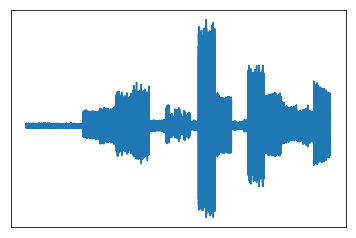

In [265]:
%matplotlib inline
plt.xticks([])
plt.yticks([])
plt.plot(DATA)
plt.show()

*Let's plot the 1st frame of train/test dataset!*

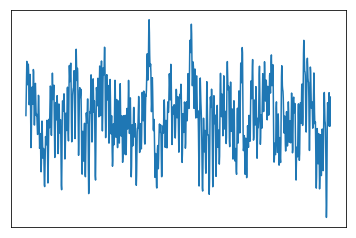

In [7]:
%matplotlib inline
I = 0
plt.xticks([])
plt.yticks([])
plt.plot(DATA[train_idx[I]:train_idx[I]+FRAME_LEN])
plt.show()

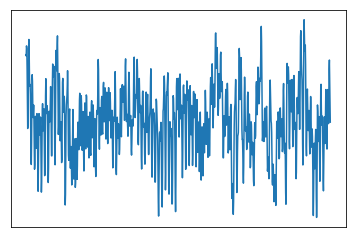

In [8]:
%matplotlib inline
I = 0
plt.xticks([])
plt.yticks([])
plt.plot(DATA[test_idx[I]:test_idx[I]+FRAME_LEN])
plt.show()

*Let's plot 1st frames of each label!*

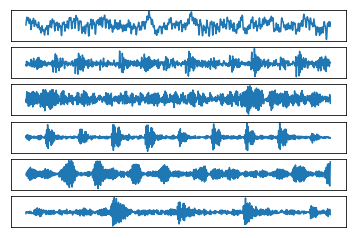

In [9]:
I = 0
for y in range(6):
    idx_labeled_y = train_idx[trainY==y]
    ax = plt.subplot(6,1,y+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(DATA[idx_labeled_y[I]:idx_labeled_y[I]+FRAME_LEN])
plt.show()

*Let's plot 1st frames of each fault diameters, of 2nd label!*

- label = 0, diameters = [0]
- label = 1/2, diameters = [1,2,3,4]
- label = 3, diameters = [1,2,3]
- label = 4/5, diameters = [1,3]

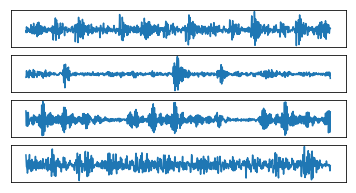

In [10]:
%matplotlib inline
I=0
y=1
for d in range(1,5):
    idx_diameter_d = train_idx[(trainY==y)&(train_diameter==d)]
    ax = plt.subplot(5,1,d+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(DATA[idx_diameter_d[I]:idx_diameter_d[I]+FRAME_LEN])
plt.show()

*Now plot 1st frames of all combinations of (frame, label, fault diameter)!*

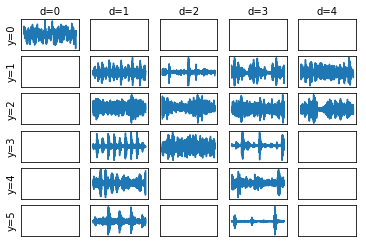

In [11]:
%matplotlib inline
I = 0
for y in range(6):
    for d in range(5):
        ax = plt.subplot(6,5,5*y+d+1)
        if y==0:
            ax.set_xlabel('d=%d'%d)
            ax.xaxis.set_label_position('top')
        if d==0:
            ax.set_ylabel('y=%d'%y)
        ax.set_xticks([])
        ax.set_yticks([])
        idx_oi = train_idx[(trainY==y)&(train_diameter==d)]
        if idx_oi.shape[0]==0:
            continue
        ax.plot(DATA[idx_oi[I]:idx_oi[I]+FRAME_LEN])
    
plt.show()

## 3. Supervised Learning!!!

In [266]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [267]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=True

### 3.1 Model Definition
simple model
you can also look up on the source code

In [268]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.enc_layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer3 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer4 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        self.classifier1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier3 = nn.Linear(32, 6)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m)==nn.Linear or type(m)==nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x, get_latent=False):
        x = self.enc_layer1(x)
        x = self.enc_layer2(x)
        x = self.enc_layer3(x)
        x = self.enc_layer4(x)
        
        x = x.mean(dim=-1)
        z = x
        
        x = self.classifier1(x)        
        x = self.classifier2(x)     
        x = self.classifier3(x)
        
        if get_latent:
            return x,z
        else:
            return x
    

### 3.2 Train Configurations

train & get the score

In [269]:
LR = 1e-3
BATCH = 128
EPOCH = 500
TOL = 10
SAVE_PATH = './saved_models'
SAV_INTV = 10
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [270]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [271]:
model = SimpleModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [272]:
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


### 3.3 Training Functions
Implemented in the source

In [273]:
def batch_step(model, X, Y, M=None, train=False, optimizer=None):
    if M is None:
        M = torch.zeros_like(Y) == 0
        M = M.to(device=X.device, dtype=torch.bool)
    p = model(X)
    
    pred = torch.argmax(p, dim=1)
    
    
    class_loss = torch.tensor(0.0).to(device=X.device)
    if M.any():
        class_loss += nn.CrossEntropyLoss()(p[M],Y[M])

        if train:
            class_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    return class_loss, pred

In [274]:
def epoch_step(model, data_idx, dataY, data, train=False, shuffle=None, mask=None, optimizer=None, batch_step=batch_step, device=None,batch=128,frame_len=1024):
    if shuffle is None:
        shuffle = np.arange(data_idx.shape[0])
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    avg_loss = 0.0
    n = 0
    n_correct = 0
    n_wrong = 0
    for b in range((shuffle.shape[0]-1)//batch+1):
        X = data[data_idx[shuffle[b*batch:(b+1)*batch]][:,None]+np.arange(frame_len)]
        Y = dataY[shuffle[b*batch:(b+1)*batch]]
        X = np.transpose(X, [0,2,1])
        X = torch.tensor(X, device=device, dtype=torch.float)
        Y = torch.tensor(Y, device=device, dtype=torch.long)
        Yall = Y.clone()
        if mask is None:
            M = None
        else:
            M = mask[shuffle[b*batch:(b+1)*batch]]
            M = torch.tensor(M, device=device, dtype=torch.bool)
            Y[~M]=0
        loss, pred = batch_step(model, X, Y, train=train, optimizer=optimizer, M=M)
        correct = (Yall[Yall==pred]).shape[0]
        wrong = (Yall[Yall!=pred]).shape[0]
        avg_loss = (avg_loss*n + loss.item()*X.shape[0])/(n+X.shape[0])
        n += X.shape[0]
        n_correct += correct
        n_wrong += wrong
    return avg_loss, n_correct/(n_correct+n_wrong)

def train(model, optimizer, train_idx, trainY, data, model_name, train_shuffle, val_shuffle, mask=None, batch_step=batch_step, sav_intv=10, tol=10, sav_path = './', device=None, epoch=500, batch=128,frame_len=1024):
    best_eval = float('inf')
    for e in range(epoch):
        timestamp = time.time()
        
        model.train()
        train_loss, train_acc = epoch_step(model, train_idx, trainY, data, train=True, optimizer=optimizer, shuffle=train_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)
        model.eval()
        with torch.no_grad():
            eval_loss, eval_acc = epoch_step(model, train_idx, trainY, data, train=False, shuffle=val_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)
        
        print('(%.2fs)[Epoch %d]'%(time.time()-timestamp, e+1))
        print('\t(train) loss : %.5f,\tacc : %.5f'%(train_loss, train_acc))
        print('\t(eval) loss : %.5f,\tacc : %.5f'%(eval_loss, eval_acc))
        
        if eval_loss < best_eval:
            best_eval = eval_loss
            patience = 0
            torch.save(model.state_dict(), '%s/%s_best.pth'%(sav_path, model_name))
        if e%sav_intv == sav_intv-1:
            torch.save(model.state_dict(), '%s/%s_e%d.pth'%(sav_path, model_name, e+1))
        patience += 1
        if patience > tol:
            print('Early stop at Epoch %d'%(e+1))
            break

### 3.4 Start Training

In [275]:
TRAIN_PARAMS = {
    'model' : model,
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : None,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [276]:
train(**TRAIN_PARAMS)

(1.91s)[Epoch 1]
	(train) loss : 1.63021,	acc : 0.29860
	(eval) loss : 1.46837,	acc : 0.34538
(1.84s)[Epoch 2]
	(train) loss : 1.06491,	acc : 0.52390
	(eval) loss : 0.64195,	acc : 0.67359
(1.86s)[Epoch 3]
	(train) loss : 0.61708,	acc : 0.73084
	(eval) loss : 0.34962,	acc : 0.87974
(1.84s)[Epoch 4]
	(train) loss : 0.39954,	acc : 0.84873
	(eval) loss : 0.22399,	acc : 0.92448
(2.09s)[Epoch 5]
	(train) loss : 0.30958,	acc : 0.88695
	(eval) loss : 0.15033,	acc : 0.95204
(1.90s)[Epoch 6]
	(train) loss : 0.22543,	acc : 0.92231
	(eval) loss : 0.08789,	acc : 0.98067
(1.83s)[Epoch 7]
	(train) loss : 0.18256,	acc : 0.93520
	(eval) loss : 0.07172,	acc : 0.98175
(1.85s)[Epoch 8]
	(train) loss : 0.15162,	acc : 0.94791
	(eval) loss : 0.05304,	acc : 0.98568
(1.93s)[Epoch 9]
	(train) loss : 0.12433,	acc : 0.95847
	(eval) loss : 0.04119,	acc : 0.98962
(1.91s)[Epoch 10]
	(train) loss : 0.12351,	acc : 0.95775
	(eval) loss : 0.05180,	acc : 0.98676
(2.03s)[Epoch 11]
	(train) loss : 0.10392,	acc : 0.96500
	(

(1.79s)[Epoch 88]
	(train) loss : 0.01470,	acc : 0.99561
	(eval) loss : 0.00149,	acc : 0.99928
(1.83s)[Epoch 89]
	(train) loss : 0.01344,	acc : 0.99597
	(eval) loss : 0.00240,	acc : 0.99928
Early stop at Epoch 89


### 3.5 Testing

In [214]:
def test(model, test_idx, testY, data, model_name, batch_step=batch_step, sav_path = './', device=None, batch=128,frame_len=1024, load_version='best'):
    timestamp = time.time()
    
    model.load_state_dict(torch.load('%s/%s_%s.pth'%(sav_path, model_name, load_version)))
    
    model.eval()
    with torch.no_grad():
        loss, acc = epoch_step(model, test_idx, testY, data, train=False, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)

    print('Test Result of model <%s>:%s'%(model_name, load_version))
    print('  [Loss]\t%.5f'%(loss))
    print('  [Accuracy]\t%.2f%%'%(acc*100))
    

In [215]:
TEST_PARAMS = {
    'model' : model,
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [140]:
test(**TEST_PARAMS)

Test Result of model <tutorial_supervised>:best
  [Loss]	0.03160
  [Accuracy]	98.98%


### 3.6 Latent Vector Analysis
plot tsne color according to true y, prediction, diameter, rpm
you can do yourself on RepresentationAnalysis.ipynb

In [216]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.experiment import get_latents

In [217]:
z, preds = get_latents(**TEST_PARAMS)
z = z.cpu().numpy()
preds = preds.cpu().numpy()
print(z.shape, preds.shape)

RuntimeError: Error(s) in loading state_dict for SimpleModel:
	Missing key(s) in state_dict: "enc_layer1.0.weight", "enc_layer1.0.bias", "enc_layer2.0.weight", "enc_layer2.0.bias", "enc_layer3.0.weight", "enc_layer3.0.bias", "enc_layer4.0.weight", "enc_layer4.0.bias", "classifier1.0.weight", "classifier1.0.bias", "classifier2.0.weight", "classifier2.0.bias". 
	Unexpected key(s) in state_dict: "enc_layer1.weight", "enc_layer1.bias", "enc_layer2.weight", "enc_layer2.bias", "enc_layer3.weight", "enc_layer3.bias", "enc_layer4.weight", "enc_layer4.bias", "classifier1.weight", "classifier1.bias", "classifier2.weight", "classifier2.bias". 

In [ ]:
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

In [218]:
def draw_plot(tsne, label, cmap = None, legend = False, ax=None):
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    if cmap is None:
        cmap = plt.cm.get_cmap('coolwarm')
    if not legend:
        ax.scatter(tsne[:,0], tsne[:,1], s=1, cmap=cmap, c=label, picker=5)
    else:
        set_l = set(label)
        for i, l in enumerate(set_l):
            ax.scatter(tsne[:,0][label==l], tsne[:,1][label==l], c=cmap(i/len(set_l)), cmap=cmap, label=l, s=1, picker=5)
            ax.legend()
    plt.show()

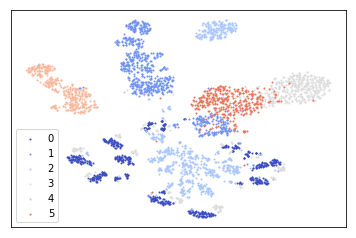

In [127]:
%matplotlib inline
draw_plot(z_tsne, label=testY, legend=True)

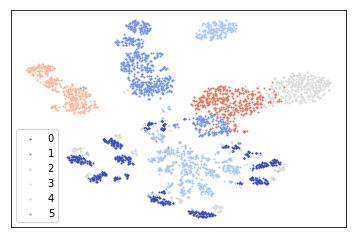

In [128]:
%matplotlib inline
draw_plot(z_tsne, label=preds, legend=True)

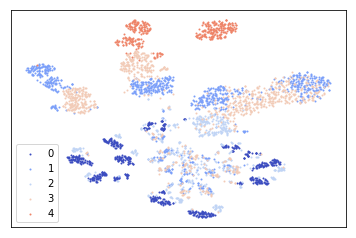

In [129]:
%matplotlib inline
draw_plot(z_tsne, label=test_diameter, legend=True)

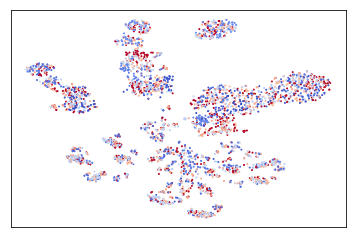

In [130]:
%matplotlib inline
draw_plot(z_tsne, label=test_rpm)

In [219]:
def draw_magic(tsne, label, raw, index, cmap = None, frame_len=1024, frame_intv=512):
    global p, m,pick
    p=None
    fig=plt.figure(figsize=(8,8))
    ax0 = plt.subplot2grid((4,1),(0,0),rowspan=3)#(3,1,1)
    ax1 = plt.subplot(414)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    m=0
    pick=False
    text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
    def onpress(event):
        global m,pick
        if event.key=='right' and m < len(label)-1:
            m+=1
        elif event.key == 'left' and m > 0:
            m-=1
        else:
            return
        if pick:
            p.remove()
            pick=False
        ax0.cla()
        ax0.set_xticks([])
        ax0.set_yticks([])
        text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
        draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
        fig.canvas.draw()
        
    def onpick(event):
        global p,pick
        pt = event.ind[0]
        if pick:
            p.remove()
            pick=False
        p = ax0.scatter(tsne[pt,0],tsne[pt,1],marker='x',s=10,c='k')
        pick=True
        
        ax1.cla()
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.plot(raw[index[pt]:index[pt]+frame_len][:,0])
        fig.canvas.draw()
        
    cid = fig.canvas.mpl_connect('pick_event', onpick)
    cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
    draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
    plt.show()

In [1]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

NameError: name 'draw_magic' is not defined

## 4. Semisupervised Learning!!!!

### 4.1 Mask Definition
let's mask & screen some combination

In [254]:
MASK_P = 0.005
SCREEN_DIAM = 2

In [255]:
from src.utils.data_utils import show_table
SEED=0
np.random.seed(SEED)
while True:
    MASK = np.array([False]*trainY.shape[0])
    l_temp = len(MASK[(train_diameter!=SCREEN_DIAM)])
    MASK[(train_diameter!=SCREEN_DIAM)] = np.random.choice(l_temp, l_temp, replace=False) < int(MASK_P*trainY.shape[0])
    if set([0,1,2,3,4,5]).issubset(set(trainY[MASK])):
        print('SEED : %d'%SEED)
        break
    SEED+=1
    np.random.seed(SEED)
print("# of labeled data : %d"%MASK.sum())
print('# of unlabeled data : %d'%(MASK.shape[0]-MASK.sum()))
print('percentage : %.2f%%'%(100*MASK.sum()/MASK.shape[0]))

show_table(MASK, trainY, train_diameter, average=False)

SEED : 0
# of labeled data : 69
# of unlabeled data : 13897
percentage : 0.49%


		0	1	2	3	4	5	| total
0"	|	14	-	-	-	-	-	| 14
0.007"	|	-	5	4	4	6	3	| 22
0.14"	|	-	0	0	0	-	-	| 0
0.021"	|	-	2	5	5	6	5	| 23
0.028"	|	-	6	4	-	-	-	| 10
------------------------------------------------------------------------
total	|	14	13	13	9	12	8	| 69


### 4.2 Training
naive supervised learning with only labels given

In [256]:
model = SimpleModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [257]:
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


In [258]:
TRAIN_PARAMS = {
    'model' : model,
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : MASK,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [259]:
#train(model, optimizer, trainY, 'tutorial_semi', mask=MASK)
train(**TRAIN_PARAMS)

(1.28s)[Epoch 1]
	(train) loss : 0.94621,	acc : 0.13194
	(eval) loss : 0.97115,	acc : 0.12062
(1.30s)[Epoch 2]
	(train) loss : 0.93864,	acc : 0.17427
	(eval) loss : 0.97304,	acc : 0.21618
(1.26s)[Epoch 3]
	(train) loss : 0.92468,	acc : 0.22064
	(eval) loss : 0.98491,	acc : 0.21618
(1.33s)[Epoch 4]
	(train) loss : 0.88064,	acc : 0.27247
	(eval) loss : 1.03976,	acc : 0.21618
(1.25s)[Epoch 5]
	(train) loss : 0.83828,	acc : 0.36681
	(eval) loss : 0.98311,	acc : 0.39979
(1.24s)[Epoch 6]
	(train) loss : 0.83750,	acc : 0.39232
	(eval) loss : 1.06455,	acc : 0.36292
(1.26s)[Epoch 7]
	(train) loss : 0.80884,	acc : 0.36976
	(eval) loss : 0.96707,	acc : 0.42126
(1.41s)[Epoch 8]
	(train) loss : 0.78202,	acc : 0.38364
	(eval) loss : 1.02848,	acc : 0.42090
(1.30s)[Epoch 9]
	(train) loss : 0.73038,	acc : 0.39617
	(eval) loss : 0.96321,	acc : 0.43164
(1.26s)[Epoch 10]
	(train) loss : 0.65151,	acc : 0.38516
	(eval) loss : 1.17780,	acc : 0.42162
(1.27s)[Epoch 11]
	(train) loss : 0.58484,	acc : 0.39089
	(

### 4.3 Testing
test

In [226]:
TEST_PARAMS = {
    'model' : model,
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [229]:
test(**TEST_PARAMS)

Test Result of model <tutorial_semi>:best
  [Loss]	1.30158
  [Accuracy]	42.87%


In [230]:
from src.experiment import score_table
score_table(diameter = test_diameter, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	1.0	-	-	-	-	-	| 1.0
0.007"	|	-	0.115	0.921	0.526	0.0	0.0	| 0.312
0.14"	|	-	0.015	0.760	0.0	-	-	| 0.258
0.021"	|	-	0.078	0.958	0.515	0.0	0.0	| 0.310
0.028"	|	-	0.057	0.502	-	-	-	| 0.278
------------------------------------------------------------------------
total	|	1.0	0.066	0.786	0.347	0.0	0.0	| 0.428


low score, tsne of train&unlabeled+test data

make your own model for semisupervised learning on Project.ipynb

In [38]:
z, preds = get_latents(**TEST_PARAMS)
z = z.cpu().numpy()
preds = preds.cpu().numpy()
print(z.shape, preds.shape)

NameError: name 'get_latents' is not defined

In [39]:
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

NameError: name 'TSNE' is not defined

In [40]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

NameError: name 'draw_magic' is not defined

In [61]:
TEST_PARAMS = {
    'model' : model,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [62]:
test(**TEST_PARAMS, test_idx = train_idx, testY = trainY)

Test Result of model <tutorial_semi>:best
  [Loss]	1.64368
  [Accuracy]	49.66%


In [63]:
test(**TEST_PARAMS, test_idx=train_idx[MASK], testY=trainY[MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	0.79878
  [Accuracy]	71.01%


In [64]:
test(**TEST_PARAMS, test_idx=train_idx[~MASK], testY=trainY[~MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	1.65641
  [Accuracy]	49.93%


In [193]:
z_train, preds_train = get_latents(**TEST_PARAMS, test_idx=train_idx, testY=trainY)
z_train = z_train.cpu().numpy()
preds_train = preds_train.cpu().numpy()

In [194]:
tsne = TSNE(n_components=2)
z_tsne_train = tsne.fit_transform(z_train)
print(z_tsne_train.shape)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


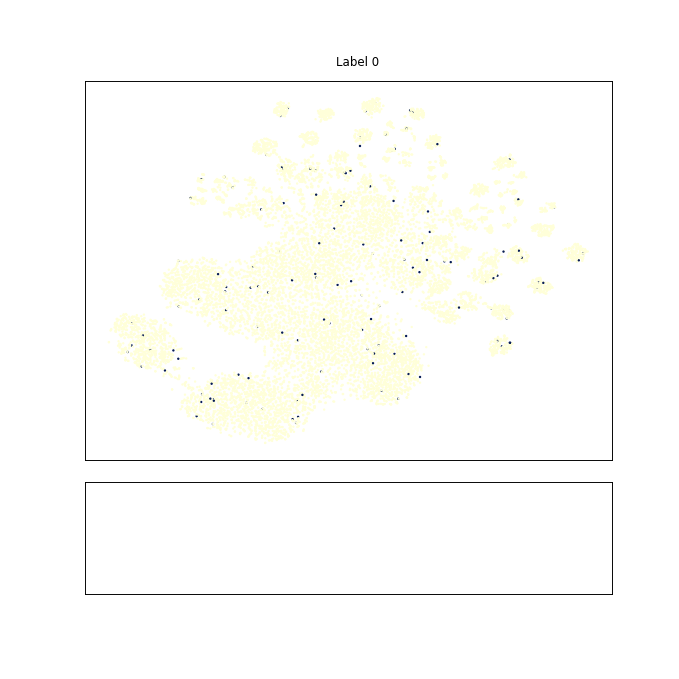

In [174]:
%matplotlib notebook
draw_magic(z_tsne_train, [MASK,preds_train, trainY, train_diameter, train_rpm], DATA, train_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV, cmap='YlGnBu')